# Extending FCv3

The models provided with fractinalcover3 are all fitted using JRSRP landsat surface reflectance. You can bring your own model and use it in the same framework though. You will need the `tensorflow` package and the `planetary_computer` package.

In [1]:
import tensorflow as tf
import tflite_runtime.interpreter as tflite

2022-08-17 23:45:50.292655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib
2022-08-17 23:45:50.292688: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import json
from datetime import datetime, timedelta

import boto3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer
import rasterio as rio
import rasterio.features as features
from fractionalcover3 import data, unmix_fractional_cover
from pystac_client import Client
from rasterio.plot import show
from rasterio.windows import Window, from_bounds
from shapely import wkt
from shapely.geometry import shape

The field data is available publicly at https://field.jrsrp.com/. For each point, I extracted the usgs landsat C2L2 surface reflectance data.

In [3]:
field = pd.read_csv("../data/star_transects.csv")
usgsref = pd.read_csv("../data/star_transects_usgs_ref.csv")

In [4]:
usgsref[
    [
        "fid",
        "datetime",
        "platform",
        "scene_id",
        "blue_sf_mn",
        "green_sf_mn",
        "red_sf_mn",
        "nir08_sf_mn",
        "swir16_sf_mn",
        "swir22_sf_mn",
        "cloudqa_s3",
    ]
]

fid  \
0      star_transects.fid-39cdd43e_1822627d2fb_-60bb   
1      star_transects.fid-39cdd43e_1822627d2fb_-60bb   
2      star_transects.fid-39cdd43e_1822627d2fb_-60ba   
3      star_transects.fid-39cdd43e_1822627d2fb_-60ba   
4      star_transects.fid-39cdd43e_1822627d2fb_-60b9   
...                                              ...   
20666  star_transects.fid-39cdd43e_1822627d2fb_-4faf   
20667  star_transects.fid-39cdd43e_1822627d2fb_-4faf   
20668  star_transects.fid-39cdd43e_1822627d2fb_-4fae   
20669  star_transects.fid-39cdd43e_1822627d2fb_-4fae   
20670  star_transects.fid-39cdd43e_1822627d2fb_-4fae   

                          datetime   platform               scene_id  \
0      2010-08-10T00:25:21.744638Z  LANDSAT_7  LE70970832010222ASA00   
1      2010-07-25T00:25:23.005764Z  LANDSAT_7  LE70970832010206ASN00   
2      2010-08-10T00:25:21.744638Z  LANDSAT_7  LE70970832010222ASA00   
3      2010-07-25T00:25:23.005764Z  LANDSAT_7  LE70970832010206ASN00   
4      2010-08-10T00:25:21.744638Z  LANDSAT_7  LE70970832010222ASA00   
...                            ...        ...                    ...   
20666  2016-08-28T00:19:05.033730Z  LANDSAT_7  LE70950722016241ASA00   
20667  2016-08-27T00:22:44.750755Z  LANDSAT_8  LC80960722016240LGN01   
20668  2015-08-28T00:06:17.307411Z  LANDSAT_7  LE70930782015240ASA00   
20669  2015-08-20T00:06:11.600682Z  LANDSAT_8  LC80930782015232LGN01   
20670  2015-08-12T00:06:16.678727Z  LANDSAT_7  LE70930782015224ASA00   

         blue_sf_mn   green_sf_mn     red_sf_mn   nir08_sf_mn  swir16_sf_mn  \
0       9465.000000  10556.666667  12563.333333  15378.666667  17962.888889   
1       9110.222222   9857.777778  11326.777778  13604.333333  14998.222222   
2      16489.555556  15911.555556  17065.444444  18282.333333  17893.333333   
3       8930.777778   9765.555556  11503.000000  14127.111111  17757.777778   
4      11353.777778  11887.111111  13778.888889  15604.000000  18369.333333   
...             ...           ...           ...           ...           ...   
20666  13465.888889  13843.000000  13927.555556  17650.333333  16107.444444   
20667   7763.666667   8291.666667   8231.555556  15067.555556  10782.888889   
20668   8178.444444   8223.666667   8170.111111   9361.777778   9079.444444   
20669   8486.111111   9101.000000   9391.888889  13186.777778  14298.444444   
20670   8536.333333   9088.000000   9404.666667  12662.666667  14080.000000   

       swir22_sf_mn  cloudqa_s3  
0      16367.111111         0.0  
1      13724.444444         0.0  
2      15265.444444         8.0  
3      15608.555556         0.0  
4      16935.888889         4.0  
...             ...         ...  
20666  14619.555556         8.0  
20667   8824.444444         NaN  
20668   8367.111111         4.0  
20669  12193.444444         NaN  
20670  11986.000000         0.0  

[20671 rows x 11 columns]

The field data has entries like 'overstory green', 'mid branch', 'dead', 'crust', 'green' and 'crypto'. These are commonly aggregated in a way to calculate fractional over. The next function illustrates this, written by [@bexdunn](https://github.com/BexDunn),
and available on her [Validation_Field_C3](https://github.com/GeoscienceAustralia/dea-notebooks/blob/FC_Val_C3/Fractional_Cover_C3_Val/Validation_Field_C3.ipynb) notebok.

In [5]:
# this si from https://github.com/GeoscienceAustralia/dea-notebooks/blob/FC_Val_C3/Fractional_Cover_C3_Val/Validation_Field_C3.ipynb
def fractionalCoverSatView(siteProperties):
    """equations to calculate fractional cover from the csv data"""
    nTotal = siteProperties["num_points"]

    # Canopy Layer
    nCanopyBranch = siteProperties["over_b"] * nTotal / 100.0
    nCanopyDead = siteProperties["over_d"] * nTotal / 100.0
    nCanopyGreen = siteProperties["over_g"] * nTotal / 100.0

    # Midstory Layer
    nMidBranch = siteProperties["mid_b"] * nTotal / 100.0
    nMidGreen = siteProperties["mid_g"] * nTotal / 100.0
    nMidDead = siteProperties["mid_d"] * nTotal / 100.0

    # Ground Layer
    nGroundDeadLitter = (
        (siteProperties["dead"] + siteProperties["litter"]) * nTotal / 100.0
    )
    nGroundCrustDistRock = (
        (siteProperties["crust"] + siteProperties["dist"] + siteProperties["rock"])
        * nTotal
        / 100.0
    )
    nGroundGreen = siteProperties["green"] * nTotal / 100.0
    nGroundCrypto = siteProperties["crypto"] * nTotal / 100.0

    # Work out the canopy elements as viewed from above
    canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
    canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
    canopyBranchProjectiveCover = (
        nCanopyBranch
        / nTotal
        * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
    )
    canopyPlantProjectiveCover = (nCanopyGreen + nCanopyDead + nCanopyBranch) / nTotal

    # Work out the midstorey fractions
    midFoliageProjectiveCover = nMidGreen / nTotal
    midDeadProjectiveCover = nMidDead / nTotal
    midBranchProjectiveCover = nMidBranch / nTotal
    midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal

    # Work out the midstorey  elements as viewed by the satellite using a gap fraction method
    satMidFoliageProjectiveCover = midFoliageProjectiveCover * (
        1 - canopyPlantProjectiveCover
    )
    satMidDeadProjectiveCover = midDeadProjectiveCover * (
        1 - canopyPlantProjectiveCover
    )
    satMidBranchProjectiveCover = midBranchProjectiveCover * (
        1 - canopyPlantProjectiveCover
    )
    satMidPlantProjectiveCover = midPlantProjectiveCover * (
        1 - canopyPlantProjectiveCover
    )

    # Work out the groundcover fractions as seen by the observer
    groundPVCover = nGroundGreen / nTotal
    groundNPVCover = nGroundDeadLitter / nTotal
    groundBareCover = nGroundCrustDistRock / nTotal
    groundCryptoCover = nGroundCrypto / nTotal
    groundTotalCover = (
        nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock
    ) / nTotal

    # Work out the ground cover proportions as seen by the satellite
    satGroundPVCover = (
        groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    )
    satGroundNPVCover = (
        groundNPVCover
        * (1 - midPlantProjectiveCover)
        * (1 - canopyPlantProjectiveCover)
    )
    satGroundBareCover = (
        groundBareCover
        * (1 - midPlantProjectiveCover)
        * (1 - canopyPlantProjectiveCover)
    )
    satGroundCryptoCover = (
        groundCryptoCover
        * (1 - midPlantProjectiveCover)
        * (1 - canopyPlantProjectiveCover)
    )
    satGroundTotalCover = (
        groundTotalCover
        * (1 - midPlantProjectiveCover)
        * (1 - canopyPlantProjectiveCover)
    )

    # Final total covers calculated using gap probabilities through all layers
    totalPVCover = (
        canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
    )
    totalNPVCover = (
        canopyDeadProjectiveCover
        + canopyBranchProjectiveCover
        + satMidDeadProjectiveCover
        + satMidBranchProjectiveCover
        + satGroundNPVCover
    )
    totalBareCover = satGroundBareCover
    totalCryptoCover = satGroundCryptoCover

    return np.array([totalPVCover, totalNPVCover + totalCryptoCover, totalBareCover])

Applying that function to our field data...

In [6]:
# Calculate field measured fractions
field = field.merge(
    field.apply(fractionalCoverSatView, axis=1, result_type="expand").rename(
        columns={0: "total_pv", 1: "total_npv", 2: "total_bs"}
    ),
    left_index=True,
    right_index=True,
)

In [7]:
field[["FID", "obs_key", "total_pv", "total_npv", "total_bs"]]

FID  \
0     star_transects.fid-39cdd43e_1822627d2fb_-60bb   
1     star_transects.fid-39cdd43e_1822627d2fb_-60ba   
2     star_transects.fid-39cdd43e_1822627d2fb_-60b9   
3     star_transects.fid-39cdd43e_1822627d2fb_-60b8   
4     star_transects.fid-39cdd43e_1822627d2fb_-60b7   
...                                             ...   
4361  star_transects.fid-39cdd43e_1822627d2fb_-4fb2   
4362  star_transects.fid-39cdd43e_1822627d2fb_-4fb1   
4363  star_transects.fid-39cdd43e_1822627d2fb_-4fb0   
4364  star_transects.fid-39cdd43e_1822627d2fb_-4faf   
4365  star_transects.fid-39cdd43e_1822627d2fb_-4fae   

                                obs_key  total_pv  total_npv  total_bs  
0     13929235_03307257_20100728_000000  0.106769   0.437330  0.455901  
1     13948505_03312038_20100728_000000  0.108840   0.535715  0.355361  
2     13943693_03317687_20100728_000000  0.035996   0.180644  0.783456  
3     13943905_03317231_20100728_000000  0.079918   0.289545  0.630631  
4     11822867_03150279_20101011_000000  0.025000   0.455000  0.520000  
...                                 ...       ...        ...       ...  
4361  14925996_02920954_20110728_083559       NaN        NaN       NaN  
4362  15006407_02873163_20110727_083900       NaN        NaN       NaN  
4363  14802973_03192939_20110609_114500       NaN        NaN       NaN  
4364  14555271_01710784_20160906_045500       NaN        NaN       NaN  
4365  14747060_02571617_20150821_022300       NaN        NaN       NaN  

[4366 rows x 5 columns]

In [8]:
fractional_obs = field[["FID", "obs_key", "total_pv", "total_npv", "total_bs"]]

In [9]:
fractional_df = fractional_obs.merge(
    usgsref[
        [
            "fid",
            "datetime",
            "platform",
            "scene_id",
            "blue_sf_mn",
            "green_sf_mn",
            "red_sf_mn",
            "nir08_sf_mn",
            "swir16_sf_mn",
            "swir22_sf_mn",
        ]
    ],
    how="right",
    left_on="FID",
    right_on="fid",
)
fractional_df.pop("fid")
fractional_df = fractional_df[fractional_df.total_pv.notnull()]
fractional_df = fractional_df[fractional_df.green_sf_mn.notnull()]
fractional_df

FID  \
0      star_transects.fid-39cdd43e_1822627d2fb_-60bb   
1      star_transects.fid-39cdd43e_1822627d2fb_-60bb   
2      star_transects.fid-39cdd43e_1822627d2fb_-60ba   
3      star_transects.fid-39cdd43e_1822627d2fb_-60ba   
4      star_transects.fid-39cdd43e_1822627d2fb_-60b9   
...                                              ...   
20438  star_transects.fid-39cdd43e_1822627d2fb_-4fde   
20439  star_transects.fid-39cdd43e_1822627d2fb_-4fde   
20440  star_transects.fid-39cdd43e_1822627d2fb_-4fdd   
20441  star_transects.fid-39cdd43e_1822627d2fb_-4fdd   
20442  star_transects.fid-39cdd43e_1822627d2fb_-4fdd   

                                 obs_key  total_pv  total_npv  total_bs  \
0      13929235_03307257_20100728_000000  0.106769   0.437330  0.455901   
1      13929235_03307257_20100728_000000  0.106769   0.437330  0.455901   
2      13948505_03312038_20100728_000000  0.108840   0.535715  0.355361   
3      13948505_03312038_20100728_000000  0.108840   0.535715  0.355361   
4      13943693_03317687_20100728_000000  0.035996   0.180644  0.783456   
...                                  ...       ...        ...       ...   
20438  13798943_02292280_20160610_000000  0.103000   0.304000  0.594000   
20439  13798943_02292280_20160610_000000  0.103000   0.304000  0.594000   
20440  13799578_02218891_20160608_000000  0.084509   0.748049  0.167442   
20441  13799578_02218891_20160608_000000  0.084509   0.748049  0.167442   
20442  13799578_02218891_20160608_000000  0.084509   0.748049  0.167442   

                          datetime   platform               scene_id  \
0      2010-08-10T00:25:21.744638Z  LANDSAT_7  LE70970832010222ASA00   
1      2010-07-25T00:25:23.005764Z  LANDSAT_7  LE70970832010206ASN00   
2      2010-08-10T00:25:21.744638Z  LANDSAT_7  LE70970832010222ASA00   
3      2010-07-25T00:25:23.005764Z  LANDSAT_7  LE70970832010206ASN00   
4      2010-08-10T00:25:21.744638Z  LANDSAT_7  LE70970832010222ASA00   
...                            ...        ...                    ...   
20438  2016-06-04T00:48:34.916422Z  LANDSAT_8  LC81000762016156LGN01   
20439  2016-05-27T00:51:22.577767Z  LANDSAT_7  LE71000762016148EDC00   
20440  2016-06-20T00:48:14.696318Z  LANDSAT_8  LC81000752016172LGN01   
20441  2016-06-04T00:48:10.974552Z  LANDSAT_8  LC81000752016156LGN01   
20442  2016-05-27T00:50:58.636707Z  LANDSAT_7  LE71000752016148EDC00   

         blue_sf_mn   green_sf_mn     red_sf_mn   nir08_sf_mn  swir16_sf_mn  \
0       9465.000000  10556.666667  12563.333333  15378.666667  17962.888889   
1       9110.222222   9857.777778  11326.777778  13604.333333  14998.222222   
2      16489.555556  15911.555556  17065.444444  18282.333333  17893.333333   
3       8930.777778   9765.555556  11503.000000  14127.111111  17757.777778   
4      11353.777778  11887.111111  13778.888889  15604.000000  18369.333333   
...             ...           ...           ...           ...           ...   
20438   8823.111111  10315.000000  12600.000000  15233.111111  20028.777778   
20439   9613.888889  11540.888889  14646.888889  17122.555556  23071.333333   
20440   8669.444444   9892.555556  10800.777778  13640.000000  15693.222222   
20441   9107.888889  10518.111111  11945.444444  15218.888889  18446.222222   
20442   9557.444444  11217.111111  13024.666667  16089.666667  19285.222222   

       swir22_sf_mn  
0      16367.111111  
1      13724.444444  
2      15265.444444  
3      15608.555556  
4      16935.888889  
...             ...  
20438  17183.000000  
20439  19937.555556  
20440  13214.333333  
20441  15479.444444  
20442  15521.000000  

[18795 rows x 14 columns]

I'm not doing it here, but you might want to filter observations based on quality, time, or other features. You also might like to consider fusion for the different sensors.

In [10]:
# Get a training Subset
train_dataset = fractional_df[
    [
        "total_pv",
        "total_npv",
        "total_bs",
        "green_sf_mn",
        "red_sf_mn",
        "nir08_sf_mn",
        "swir16_sf_mn",
        "swir22_sf_mn",
    ]
].sample(frac=0.75)
print(train_dataset.shape)

(14096, 8)


The C2 data needs to be rescaled (https://www.usgs.gov/faqs/how-do-i-use-scale-factor-landsat-level-2-science-products)

In [11]:
train_dataset[
    ["green_sf_mn", "red_sf_mn", "nir08_sf_mn", "swir16_sf_mn", "swir22_sf_mn"]
] = train_dataset[
    ["green_sf_mn", "red_sf_mn", "nir08_sf_mn", "swir16_sf_mn", "swir22_sf_mn"]
].transform(
    lambda x: x * 0.0000275 + -0.2
)

In [12]:
train_stats = train_dataset.describe()
[train_stats.pop(x) for x in ["total_bs", "total_pv", "total_npv"]]
train_stats = train_stats.transpose()
train_labels = pd.concat(
    [train_dataset.pop(x) for x in ["total_bs", "total_pv", "total_npv"]], 1
)

/tmp/ipykernel_120/1986910008.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_labels = pd.concat(


In [13]:
train_stats

count      mean       std       min       25%       50%  \
green_sf_mn   14096.0  0.178527  0.259185 -0.055735  0.086155  0.109615   
red_sf_mn     14096.0  0.230871  0.276397 -0.052823  0.123798  0.165629   
nir08_sf_mn   14096.0  0.292409  0.155639  0.007381  0.217241  0.257459   
swir16_sf_mn  14096.0  0.341979  0.132826  0.002238  0.281153  0.333540   
swir22_sf_mn  14096.0  0.253222  0.093344  0.000625  0.195018  0.247196   

                   75%       max  
green_sf_mn   0.140874  1.602213  
red_sf_mn     0.213131  1.602213  
nir08_sf_mn   0.304901  1.602213  
swir16_sf_mn  0.396134  1.602213  
swir22_sf_mn  0.312048  1.602213

In [14]:
train_dataset

green_sf_mn  red_sf_mn  nir08_sf_mn  swir16_sf_mn  swir22_sf_mn
10746     0.089199   0.187689     0.245106      0.396851      0.370206
3764      0.096636   0.128735     0.183796      0.337341      0.252839
10634     0.105864   0.140655     0.280908      0.455395      0.286814
28        1.602213   1.602213     0.901778      0.509867      0.333803
9469      0.131458   0.164127     0.232123      0.328553      0.242130
...            ...        ...          ...           ...           ...
15209     0.073170   0.100123     0.203092      0.294450      0.228633
9326      1.602213   1.602213     0.819006      0.456599      0.296143
4870      1.602213   1.602213     0.809357      0.203012      0.175794
3228      0.125762   0.176829     0.224719      0.300213      0.228973
120       0.120549   0.182663     0.250422      0.456443      0.391067

[14096 rows x 5 columns]

For fitting a multi-output model, see, for example, https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/

In [15]:
train_labels

total_bs  total_pv  total_npv
10746  0.590007  0.053159   0.356834
3764   0.115000  0.100000   0.785000
10634  0.023000  0.000000   0.977000
28     0.728446  0.029630   0.242120
9469   0.093000  0.000000   0.906000
...         ...       ...        ...
15209  0.172431  0.155287   0.672282
9326   0.015000  0.895000   0.090000
4870   0.810000  0.087000   0.103000
3228   0.284000  0.657000   0.060000
120    0.567800  0.000000   0.432200

[14096 rows x 3 columns]

In [16]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import plot_model


# get the model
def get_model(n_inputs, n_outputs):
    model = keras.Sequential()
    model.add(
        layers.Dense(
            20, input_dim=n_inputs, kernel_initializer="he_uniform", activation="relu"
        )
    )
    model.add(layers.Dense(n_outputs))
    model.compile(loss="mae", optimizer="adam")
    return model

In [17]:
model = get_model(5, 3)
model.fit(train_dataset, train_labels, verbose=0, epochs=100)

2022-08-17 23:45:54.826603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib
2022-08-17 23:45:54.826637: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-17 23:45:54.826661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (62a7f55a8741): /proc/driver/nvidia/version does not exist
2022-08-17 23:45:54.826892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
row = train_dataset.iloc[0:10]
yhat = model.predict(row)
yhat

1/1 [==============================] - 0s 83ms/step


array([[0.7223913 , 0.04776114, 0.24839312],
       [0.21103114, 0.0350174 , 0.740802  ],
       [0.04745185, 0.23231184, 0.7248658 ],
       [0.19822538, 0.21541   , 0.4693575 ],
       [0.2309418 , 0.05729225, 0.6686674 ],
       [0.0778352 , 0.18674754, 0.7260819 ],
       [0.44844615, 0.03976259, 0.49598226],
       [0.1720787 , 0.17613532, 0.51092523],
       [0.1930879 , 0.2557649 , 0.52153504],
       [0.21059439, 0.12867144, 0.6409433 ]], dtype=float32)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.predict(train_dataset)

441/441 [==============================] - 0s 848us/step


array([[0.7223913 , 0.04776114, 0.24839312],
       [0.21103114, 0.0350174 , 0.740802  ],
       [0.04745185, 0.23231184, 0.7248658 ],
       ...,
       [0.24060607, 0.25158074, 0.2820092 ],
       [0.3230673 , 0.04077737, 0.60854816],
       [0.5330813 , 0.05064145, 0.3934529 ]], dtype=float32)

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("custom.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmoplb5pe/assets


2022-08-17 23:46:32.925737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-17 23:46:32.925782: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-08-17 23:46:32.926494: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpmoplb5pe
2022-08-17 23:46:32.927546: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-17 23:46:32.927569: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpmoplb5pe
2022-08-17 23:46:32.930994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-08-17 23:46:32.931789: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-08-17 23:46:32.964669: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpmoplb5pe
2022-08

2168

In [22]:
inref = np.zeros((6, 1, 1))
inref[1:, 0, 0] = np.array(train_dataset.iloc[0])
inref = np.array([562, 825, 1088, 2056, 2951, 2187]) * 0.0001
inref.shape = (6, 1, 1)
custom_model = tflite.Interpreter(model_path="custom.tflite")
fractions = unmix_fractional_cover(inref, fc_model=custom_model)
fractions

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


array([[[0.21249981]],

       [[0.21996082]],

       [[0.5530957 ]]], dtype=float32)

 We should be able to use this model ourselves now.

In [23]:
aoi = """{ "type": "Polygon", "coordinates": [ [ [ 144.785216143841012, -34.654600165701858, 90.612191575371597 ], 
                                                 [ 144.809657226402294, -34.655482312453927, 90.620645907472834 ], 
                                                 [ 144.811437408021987, -34.633099458442217, 92.325059442153062 ], 
                                                 [ 144.786693789769487, -34.632657757557332, 90.616606308238715 ], 
                                                 [ 144.785216143841012, -34.654600165701858, 90.612191575371597 ] ]
]
}"""


study_area = json.loads(aoi)
study_area["the_geom"] = shape(study_area)
aoi_df = gpd.GeoDataFrame(study_area).set_geometry("the_geom")
aoi_df.crs = 4326

In [24]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [25]:
window_days = 15
obs_time = datetime.strptime("2020-06-25", "%Y-%m-%d")
start_time = obs_time - timedelta(days=window_days)
end_time = obs_time + timedelta(days=window_days)
timeRange = f"{start_time:%Y-%m-%d}/{end_time:%Y-%m-%d}"

In [26]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    intersects=aoi,
    datetime=timeRange,
    query={"eo:cloud_cover": {"lt": 20}},
)

In [27]:
items = search.get_all_items()

In [28]:
selected_item = items[0]

In [29]:
blue_blob = planetary_computer.sign(selected_item).assets["blue"].href
green_blob = planetary_computer.sign(selected_item).assets["green"].href
red_blob = planetary_computer.sign(selected_item).assets["red"].href
nir08_blob = planetary_computer.sign(selected_item).assets["nir08"].href
swir16_blob = planetary_computer.sign(selected_item).assets["swir16"].href
swir22_blob = planetary_computer.sign(selected_item).assets["swir22"].href

In [30]:
with rio.open(blue_blob) as blue_src, rio.open(green_blob) as green_src, rio.open(
    red_blob
) as red_src, rio.open(nir08_blob) as nir08_src, rio.open(
    swir16_blob
) as swir16_src, rio.open(
    swir22_blob
) as swir22_src:
    mytrans = blue_src.transform
    mycrs = blue_src.crs
    # get the bounds in the correct coordinates
    # and find the window
    mywindow = from_bounds(*features.bounds(aoi_df.to_crs(mycrs)), mytrans)
    nrow = int(mywindow.height)
    ncol = int(mywindow.width)
    ref = np.zeros((6, nrow, ncol))
    for band, src in enumerate(
        [blue_src, green_src, red_src, nir08_src, swir16_src, swir22_src]
    ):
        # I had to specify out_shape, sometimes the window was slightly off
        this_ref = src.read(1, window=mywindow, out_shape=(nrow, ncol))
        ref[band] = this_ref * 0.0000275 + -0.2
        ref[band][this_ref == src.profile["nodata"]] = np.nan

In [31]:
custom_model = tflite.Interpreter(model_path="custom.tflite")
tffractions = unmix_fractional_cover(ref, fc_model=custom_model)
fcLayers = np.clip(tffractions, 0, 2)
fcLayerSum = fcLayers.sum(axis=0) + np.finfo("float32").eps
fractions = fcLayers / fcLayerSum

# clamp output values. Pixels that are poorly modelled, e.g. water,
# can cause large values to be predicted. These need to be clamped
# or they causes problems when scaled and converted to Byte.
fractions[fractions > 1.0] = 1.0

In [32]:
fractions

array([[[0.04250198, 0.0387116 , 0.02399116, ..., 0.08650608,
         0.06442153, 0.07511824],
        [0.05194157, 0.0477742 , 0.02789886, ..., 0.0659606 ,
         0.07042771, 0.08010782],
        [0.05304189, 0.05303427, 0.05496753, ..., 0.03177062,
         0.05450307, 0.08188932],
        ...,
        [0.09920617, 0.09390911, 0.10053442, ..., 0.06968503,
         0.08262285, 0.08915758],
        [0.10620879, 0.10466122, 0.11114982, ..., 0.05981659,
         0.065277  , 0.08184808],
        [0.10971171, 0.09640113, 0.11612963, ..., 0.04896519,
         0.05817771, 0.07001558]],

       [[0.93288094, 0.9486135 , 0.9760087 , ..., 0.8020043 ,
         0.8480518 , 0.8215419 ],
        [0.93675035, 0.92367977, 0.972101  , ..., 0.8377825 ,
         0.83980966, 0.8087983 ],
        [0.91670775, 0.90662974, 0.8830393 , ..., 0.96822923,
         0.8540405 , 0.7418061 ],
        ...,
        [0.7586311 , 0.829317  , 0.8115404 , ..., 0.81636226,
         0.8151019 , 0.7610291 ],
        [0.7

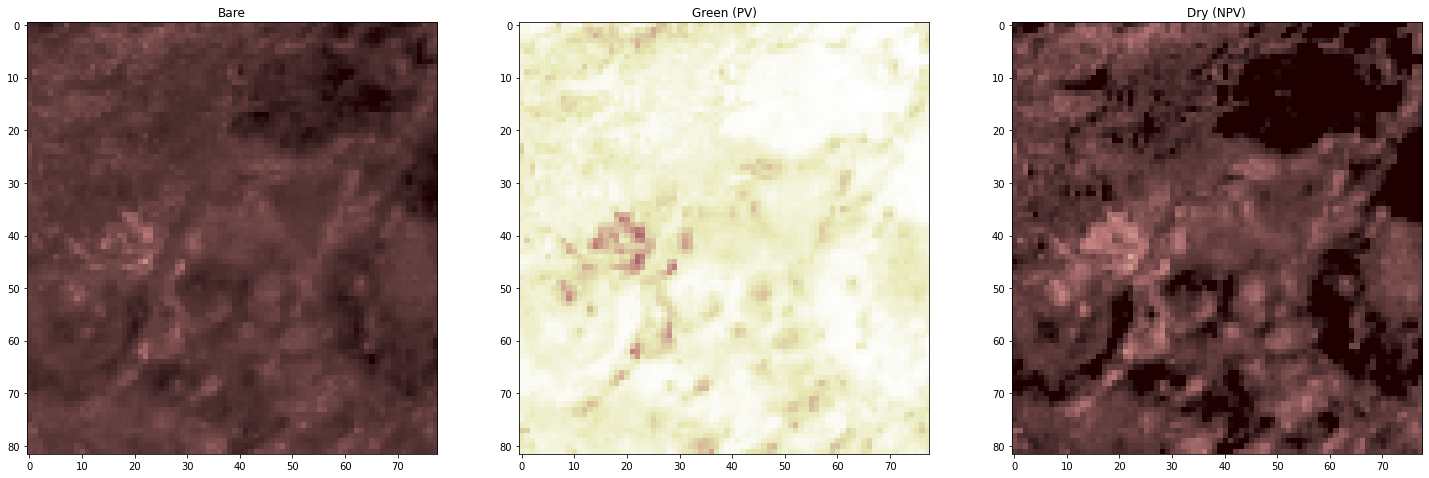

In [33]:
_min, _max = np.amin(fractions), np.amax(fractions)
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 3, 1)

# Add the vmin and vmax arguments to set the color scale
ax.imshow(fractions[0], cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax.set_adjustable("box")
ax.autoscale(False)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_adjustable("box")
ax2.imshow(fractions[1], cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax2.autoscale(False)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_adjustable("box")
ax3.imshow(fractions[2], cmap=plt.cm.pink, vmin=_min, vmax=_max)
ax3.autoscale(False)
ax.set_title("Bare")
ax2.set_title("Green (PV)")
ax3.set_title("Dry (NPV)")
plt.show()